# Computer Vision Nanodegree

## Project: Image Captioning

---

In this notebook, you will use your trained model to generate captions for images in the test dataset.

This notebook **will be graded**.  

Feel free to use the links below to navigate the notebook:
- [Step 1](#step1): Get Data Loader for Test Dataset 
- [Step 2](#step2): Load Trained Models
- [Step 3](#step3): Finish the Sampler
- [Step 4](#step4): Clean up Captions
- [Step 5](#step5): Generate Predictions!

<a id='step1'></a>
## Step 1: Get Data Loader for Test Dataset

Before running the code cell below, define the transform in `transform_test` that you would like to use to pre-process the test images.  

Make sure that the transform that you define here agrees with the transform that you used to pre-process the training images (in **2_Training.ipynb**).  For instance, if you normalized the training images, you should also apply the same normalization procedure to the test images.

In [1]:
import sys
sys.path.append('./cocoapi/PythonAPI')
from pycocotools.coco import COCO
from data_loader import get_loader
from torchvision import transforms

# TODO #1: Define a transform to pre-process the testing images.
transform_test = transforms.Compose([
transforms.Resize(256),
transforms.RandomCrop(224),
transforms.RandomHorizontalFlip(),
transforms.ToTensor(),
transforms.Normalize((0.485, 0.456, 0.406),
                    (0.229, 0.224, 0.225))])


#-#-#-# Do NOT modify the code below this line. #-#-#-#
vocab_from_file = True
# Create the data loader.
data_loader_test = get_loader(transform=transform_test, mode='test',vocab_from_file=vocab_from_file)

./cocoapi/annotations/image_info_test2014.json
File Location
./cocoapi/annotations/image_info_test2014.json
Vocabulary successfully loaded from vocab.pkl file!
File Location
./cocoapi/annotations/image_info_test2014.json


Run the code cell below to visualize an example test image, before pre-processing is applied.

original_image
tensor([[[[160, 193, 212],
          [161, 192, 210],
          [162, 191, 207],
          ...,
          [142, 170, 192],
          [142, 171, 189],
          [142, 170, 184]],

         [[160, 191, 211],
          [163, 192, 210],
          [165, 192, 209],
          ...,
          [139, 167, 189],
          [139, 166, 185],
          [137, 165, 179]],

         [[163, 191, 212],
          [164, 191, 210],
          [165, 192, 211],
          ...,
          [143, 169, 192],
          [140, 167, 186],
          [138, 164, 177]],

         ...,

         [[ 52,  68,  93],
          [ 51,  67,  92],
          [ 53,  69,  94],
          ...,
          [ 51,  67,  90],
          [ 51,  69,  91],
          [ 49,  70,  87]],

         [[ 51,  69,  91],
          [ 51,  69,  91],
          [ 53,  71,  95],
          ...,
          [ 47,  63,  89],
          [ 46,  63,  89],
          [ 44,  65,  82]],

         [[ 49,  70,  91],
          [ 51,  72,  93],
          [ 55,  75, 

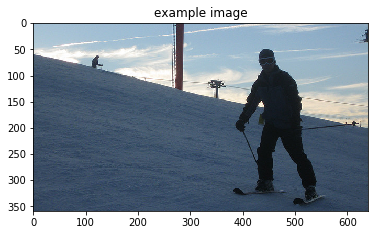

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Obtain sample image before and after pre-processing.
orig_image, image = next(iter(data_loader_test))

print("original_image")
print(orig_image)

print(image)

# Visualize sample image, before pre-processing.
plt.imshow(np.squeeze(orig_image))
plt.title('example image')
plt.show()

<a id='step2'></a>
## Step 2: Load Trained Models

In the next code cell we define a `device` that you will use move PyTorch tensors to GPU (if CUDA is available).  Run this code cell before continuing.

In [3]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')


cuda
Quadro RTX 5000
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


Before running the code cell below, complete the following tasks.

### Task #1

In the next code cell, you will load the trained encoder and decoder from the previous notebook (**2_Training.ipynb**).  To accomplish this, you must specify the names of the saved encoder and decoder files in the `models/` folder (e.g., these names should be `encoder-5.pkl` and `decoder-5.pkl`, if you trained the model for 5 epochs and saved the weights after each epoch).  

### Task #2

Plug in both the embedding size and the size of the hidden layer of the decoder corresponding to the selected pickle file in `decoder_file`.

In [4]:
# Watch for any changes in model.py, and re-load it automatically.
import os
import torch
from model import EncoderCNN, DecoderRNN

# TODO #2: Specify the saved models to load.
encoder_file = 'encoder-3.pkl' 
decoder_file = 'decoder-3.pkl'

# TODO #3: Select appropriate values for the Python variables below.
embed_size = 512
hidden_size = 512

# The size of the vocabulary.
vocab_size = len(data_loader_test.dataset.vocab)

# Initialize the encoder and decoder, and set each to inference mode.
encoder = EncoderCNN(embed_size)
encoder.eval()
decoder = DecoderRNN(embed_size, hidden_size, vocab_size)
decoder.eval()

# Load the trained weights.
encoder.load_state_dict(torch.load(os.path.join('./models', encoder_file)))
decoder.load_state_dict(torch.load(os.path.join('./models', decoder_file)))

# Move models to GPU if CUDA is available.
encoder.to(device)
decoder.to(device)

DecoderRNN(
  (dropout): Dropout(p=0.5, inplace=False)
  (embed): Embedding(8856, 512)
  (lstm): LSTM(512, 512, num_layers=2, batch_first=True, dropout=0.5)
  (fc_out): Linear(in_features=512, out_features=8856, bias=True)
)

<a id='step3'></a>
## Step 3: Finish the Sampler

Before executing the next code cell, you must write the `sample` method in the `DecoderRNN` class in **model.py**.  This method should accept as input a PyTorch tensor `features` containing the embedded input features corresponding to a single image.

It should return as output a Python list `output`, indicating the predicted sentence.  `output[i]` is a nonnegative integer that identifies the predicted `i`-th token in the sentence.  The correspondence between integers and tokens can be explored by examining either `data_loader.dataset.vocab.word2idx` (or `data_loader.dataset.vocab.idx2word`).

After implementing the `sample` method, run the code cell below.  If the cell returns an assertion error, then please follow the instructions to modify your code before proceeding.  Do **not** modify the code in the cell below. 

In [5]:
# Move image Pytorch Tensor to GPU if CUDA is available.
image = image.to(device)

# Obtain the embedded image features.
features_image = encoder(image).unsqueeze(1)

# Pass the embedded image features through the model to get a predicted caption.
output_caption = decoder.sample(features_image)
print('example output:', output_caption)

assert (type(output_caption)==list), "Output needs to be a Python list" 
assert all([type(x)==int for x in output_caption]), "Output should be a list of integers." 
assert all([x in data_loader_test.dataset.vocab.idx2word for x in output_caption]), "Each entry in the output needs to correspond to an integer that indicates a token in the vocabulary."

Output from FC
Predicted Index
0
Output from FC
Predicted Index
3
Output from FC
Predicted Index
169
Output from FC
Predicted Index
139
Output from FC
Predicted Index
319
Output from FC
Predicted Index
54
Output from FC
Predicted Index
3
Output from FC
Predicted Index
514
Output from FC
Predicted Index
258
Output from FC
Predicted Index
698
Output from FC
Predicted Index
18
Output from FC
Predicted Index
1
example output: [0, 3, 169, 139, 319, 54, 3, 514, 258, 698, 18, 1]


<a id='step4'></a>
## Step 4: Clean up the Captions

In the code cell below, complete the `clean_sentence` function.  It should take a list of integers (corresponding to the variable `output` in **Step 3**) as input and return the corresponding predicted sentence (as a single Python string). 

In [6]:
# TODO #4: Complete the function.
def clean_sentence(input_sentence):
    
    output_sentence = ''
    
    for single_words in [data_loader_test.dataset.vocab.idx2word.get(x) for x in input_sentence]:
        
        print(single_words)
        
        if single_words == '<end>':
            # breakout when seeing the <end> tag    
            break
        
        if single_words != '<start>' and single_words != '.' :
            output_sentence += ' ' + single_words
            
        if single_words == '.':
            output_sentence += single_words 
        
        
        
    output_sentence = output_sentence.strip()
    
    return output_sentence

After completing the `clean_sentence` function above, run the code cell below.  If the cell returns an assertion error, then please follow the instructions to modify your code before proceeding.

In [7]:
sentence = clean_sentence(output_caption)
print('example sentence:', sentence)

assert type(sentence)==str, 'Sentence needs to be a Python string!'

<start>
a
man
riding
skis
down
a
snow
covered
slope
.
<end>
example sentence: a man riding skis down a snow covered slope.


<a id='step5'></a>
## Step 5: Generate Predictions!

In the code cell below, we have written a function (`get_prediction`) that you can use to use to loop over images in the test dataset and print your model's predicted caption.

In [8]:
def get_prediction():
    orig_image_new, image_next = next(iter(data_loader_test))
    plt.imshow(np.squeeze(orig_image_new))
    plt.title('Sample Image')
    plt.show()
    image_new = image_next.to(device)
    features_new = encoder(image_new).unsqueeze(1)
    output_new = decoder.sample(features_new)    
    sentence_new = clean_sentence(output_new)
    print(sentence_new)

Run the code cell below (multiple times, if you like!) to test how this function works.

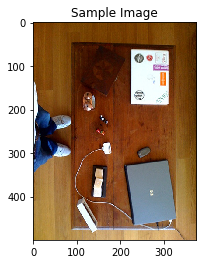

Output from FC
Predicted Index
0
Output from FC
Predicted Index
3
Output from FC
Predicted Index
1162
Output from FC
Predicted Index
13
Output from FC
Predicted Index
556
Output from FC
Predicted Index
224
Output from FC
Predicted Index
39
Output from FC
Predicted Index
257
Output from FC
Predicted Index
13
Output from FC
Predicted Index
3
Output from FC
Predicted Index
264
Output from FC
Predicted Index
112
Output from FC
Predicted Index
18
Output from FC
Predicted Index
1
<start>
a
pair
of
scissors
sitting
on
top
of
a
wooden
table
.
<end>
a pair of scissors sitting on top of a wooden table.


In [9]:
get_prediction()

As the last task in this project, you will loop over the images until you find four image-caption pairs of interest:
- Two should include image-caption pairs that show instances when the model performed well.
- Two should highlight image-caption pairs that highlight instances where the model did not perform well.

Use the four code cells below to complete this task.

### The model performed well!

Use the next two code cells to loop over captions.  Save the notebook when you encounter two images with relatively accurate captions.

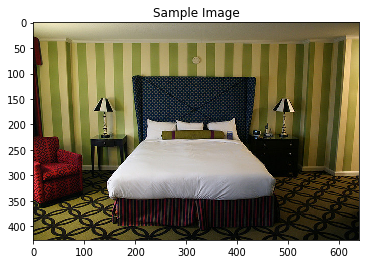

Output from FC
Predicted Index
0
Output from FC
Predicted Index
3
Output from FC
Predicted Index
325
Output from FC
Predicted Index
21
Output from FC
Predicted Index
3
Output from FC
Predicted Index
325
Output from FC
Predicted Index
6
Output from FC
Predicted Index
3
Output from FC
Predicted Index
325
Output from FC
Predicted Index
77
Output from FC
Predicted Index
46
Output from FC
Predicted Index
1
<start>
a
bed
with
a
bed
and
a
bed
in
it
<end>
a bed with a bed and a bed in it


In [10]:
get_prediction()

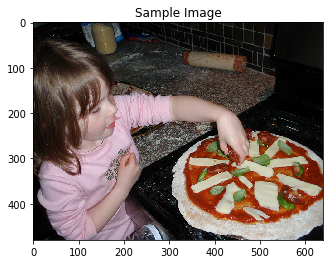

Output from FC
Predicted Index
0
Output from FC
Predicted Index
3
Output from FC
Predicted Index
169
Output from FC
Predicted Index
130
Output from FC
Predicted Index
360
Output from FC
Predicted Index
3
Output from FC
Predicted Index
2051
Output from FC
Predicted Index
77
Output from FC
Predicted Index
3
Output from FC
Predicted Index
14
Output from FC
Predicted Index
18
Output from FC
Predicted Index
1
<start>
a
man
is
holding
a
pizza
in
a
kitchen
.
<end>
a man is holding a pizza in a kitchen.


In [11]:
get_prediction()

### The model could have performed better ...

Use the next two code cells to loop over captions.  Save the notebook when you encounter two images with relatively inaccurate captions.

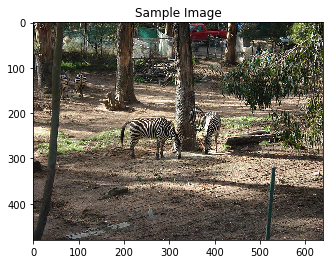

Output from FC
Predicted Index
0
Output from FC
Predicted Index
3
Output from FC
Predicted Index
1835
Output from FC
Predicted Index
170
Output from FC
Predicted Index
77
Output from FC
Predicted Index
3
Output from FC
Predicted Index
204
Output from FC
Predicted Index
13
Output from FC
Predicted Index
136
Output from FC
Predicted Index
18
Output from FC
Predicted Index
1
<start>
a
zebra
standing
in
a
field
of
grass
.
<end>
a zebra standing in a field of grass.


In [12]:
get_prediction()

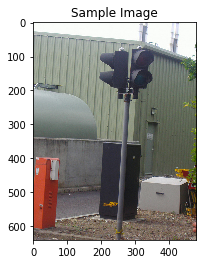

Output from FC
Predicted Index
0
Output from FC
Predicted Index
3
Output from FC
Predicted Index
33
Output from FC
Predicted Index
30
Output from FC
Predicted Index
39
Output from FC
Predicted Index
3
Output from FC
Predicted Index
906
Output from FC
Predicted Index
39
Output from FC
Predicted Index
3
Output from FC
Predicted Index
228
Output from FC
Predicted Index
33
Output from FC
Predicted Index
18
Output from FC
Predicted Index
1
<start>
a
street
sign
on
a
pole
on
a
city
street
.
<end>
a street sign on a pole on a city street.


In [13]:
get_prediction()

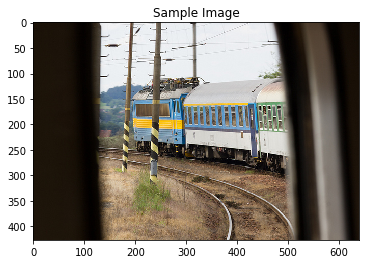

Output from FC
Predicted Index
0
Output from FC
Predicted Index
3
Output from FC
Predicted Index
854
Output from FC
Predicted Index
130
Output from FC
Predicted Index
817
Output from FC
Predicted Index
54
Output from FC
Predicted Index
32
Output from FC
Predicted Index
2485
Output from FC
Predicted Index
79
Output from FC
Predicted Index
3
Output from FC
Predicted Index
522
Output from FC
Predicted Index
18
Output from FC
Predicted Index
1
<start>
a
train
is
traveling
down
the
tracks
near
a
building
.
<end>
a train is traveling down the tracks near a building.


In [14]:
get_prediction()